In [1]:
import numpy as np 
import pandas as pd 
#import pydicom
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from PIL import Image
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
# Device configuration (GPU can be enabled in settings)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda:0


In [3]:
train_df = pd.read_csv("train_df.csv")
val_df = pd.read_csv("val_df.csv")
path = "../../data/512x512-dataset-melanoma/512x512-dataset-melanoma/"

print("Training on {} images, validating on {} images.".format(train_df.shape[0], val_df.shape[0]))

Training on 58974 images, validating on 1513 images.


In [4]:
# make sure that image ids are unique in training and validation
np.sum(np.in1d(train_df['image_id'].values, val_df['image_id'].values))

0

In [5]:
# make sure that the validation data set has enough positive examples 
train_target = train_df['target'].values
p_train = np.sum(train_target) / len(train_target)

val_target = val_df['target'].values
p_val = np.sum(val_target) / len(val_target)

In [6]:
# Convolutional neural network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=7, stride=2, padding=2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4)) 
        self.fc = nn.Sequential(
            nn.Linear(1800, 32),
            nn.BatchNorm1d(32),
            nn.Sigmoid())
        self.output = nn.Sequential(
            nn.Linear(32, 1),
            nn.Sigmoid())
        
    def embedding(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out 
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.output(out)
        return out

model = ConvNet().to(device)
model.load_state_dict(torch.load('../Models/model.ckpt'), strict=False)

<All keys matched successfully>

In [7]:
meta_features = ['sex', 'age_approx', 'anatom_site_general_challenge'] 

encoder = {}
for feature in meta_features: 
    # determine unique features  
    categories = np.unique(np.array(train_df[feature].values, str))
    for i, category in enumerate(categories): 
        if category != 'nan':
            encoder[category] = np.float(i)
encoder['nan'] = np.nan

transform = transforms.Compose(
                   [transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                    transforms.ToTensor()])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_id'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform).
        img = Image.fromarray(img)
        #img = img.resize((256, 256))
        img_processed = transform(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, meta_data, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

In [8]:
# Use the data loader.

batch_size = 64

train_dataset = Dataset(train_df, path)                                              
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size)   

model = model.eval()
for i, (images, meta_data, labels) in enumerate(train_loader):
    images = images.to(device)

    # Forward pass
    embed = model.embedding(images)
    nn_pred = model.output(embed).detach().cpu().numpy()
    embedding = embed.detach().cpu().numpy()

    # determine NN features for the set of images 
    batch_features = np.concatenate((embedding, meta_data.numpy(), nn_pred), axis=1)
    
    # append the dataset
    try:
        X = np.concatenate((X, batch_features), 0)
        y = np.append(y, labels.numpy())
    except:
        X = batch_features 
        y = labels.numpy() 

In [9]:
# Save X and y in pandas dataframe 
XGB_data = pd.DataFrame(data=X)
XGB_data['targets'] = y 
XGB_data.to_csv("XGB_train.csv", index=False)
#XGB_data = pd.read_csv("XGB_train.csv")

X = np.array(XGB_data.values[:, :-1], np.float32) 
y = np.array(XGB_data['targets'].values, np.float32)

In [10]:
# weight positive examples more heavily 
def make_weights(targets, nclasses=2):   
    count = [0] * nclasses                                                      
    for label in targets:                                                         
        count[np.int(label)] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(targets)                                              
    for idx, label in enumerate(targets):                                          
        weight[idx] = weight_per_class[np.int(label)]                                  
    return np.array(weight)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=21)

# weight positive examples more heavily 
w = make_weights(y_train)

dtrain = xgb.DMatrix(X_train, label=y_train, weight=w)
dval = xgb.DMatrix(X_val, label=y_val) 

# booster params 
param = {'max_depth': 12, 'eta': .05, 'objective': 'binary:logistic'}
param['nthread'] = 8
param['eval_metric'] = 'auc'

# specify validation set 
evallist = [(dval, 'eval')]

# Training 
num_round = 5000
bst = xgb.train(param, dtrain, num_round, evals=evallist, early_stopping_rounds=15)

[14:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1222 extra nodes, 0 pruned nodes, max_depth=12
[0]	eval-auc:0.830518
Will train until eval-auc hasn't improved in 15 rounds.
[14:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1250 extra nodes, 0 pruned nodes, max_depth=12
[1]	eval-auc:0.840752
[14:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1328 extra nodes, 0 pruned nodes, max_depth=12
[2]	eval-auc:0.841141
[14:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1240 extra nodes, 0 pruned nodes, max_depth=12
[3]	eval-auc:0.846804
[14:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1266 extra nodes, 0 pruned nodes, max_depth=12
[4]	eval-auc:0.851952
[14:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1238 extra nodes, 0 pruned nodes, max_depth=12
[5]	eval-auc:0.851979
[14:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1348 extra nodes, 0 pruned nodes, max_depth=12
[6]	eva

[14:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 772 extra nodes, 0 pruned nodes, max_depth=12
[60]	eval-auc:0.876434
[14:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1094 extra nodes, 0 pruned nodes, max_depth=12
[61]	eval-auc:0.876434
[14:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 934 extra nodes, 0 pruned nodes, max_depth=12
[62]	eval-auc:0.876658
[14:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1104 extra nodes, 0 pruned nodes, max_depth=12
[63]	eval-auc:0.876989
[14:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 948 extra nodes, 0 pruned nodes, max_depth=12
[64]	eval-auc:0.877075
[14:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 748 extra nodes, 0 pruned nodes, max_depth=12
[65]	eval-auc:0.877072
[14:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 856 extra nodes, 0 pruned nodes, max_depth=12
[66]	eval-auc:0.877013
[14:30:44] src/tree/updater_prune.cc:74

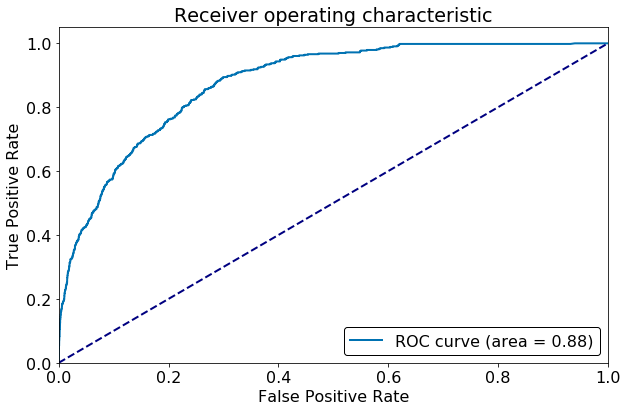

In [12]:
# prediction 
ypred = bst.predict(dval) 

fpr, tpr, _ = roc_curve(y_val, ypred)
roc_auc = auc(fpr, tpr)

plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

lw = 2
plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [13]:

batch_size = 32
valid_dataset = Dataset(val_df, path)                                               
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=batch_size)   

model = model.eval()
for i, (images, meta_data, labels) in enumerate(valid_loader):
    images = images.to(device)

    # Forward pass
    embed = model.embedding(images)
    nn_pred = model.output(embed).detach().cpu().numpy()
    embedding = embed.detach().cpu().numpy()

    # determine NN features for the set of images 
    batch_features = np.concatenate((embedding, meta_data.numpy(), nn_pred), axis=1)
    
    # append the dataset
    try:
        Xval = np.concatenate((Xval, batch_features), 0)
        yval = np.append(yval, labels.numpy())
    except:
        Xval = batch_features 
        yval = labels.numpy() 
        
XGB_data = pd.DataFrame(data=Xval)
XGB_data['targets'] = yval 
XGB_data.to_csv("XGB_val.csv", index=False)

#XGB_data = pd.read_csv("XGB_val.csv")
Xval = np.array(XGB_data.values[:, :-1], np.float32) 
yval = np.array(XGB_data['targets'].values, np.float32)

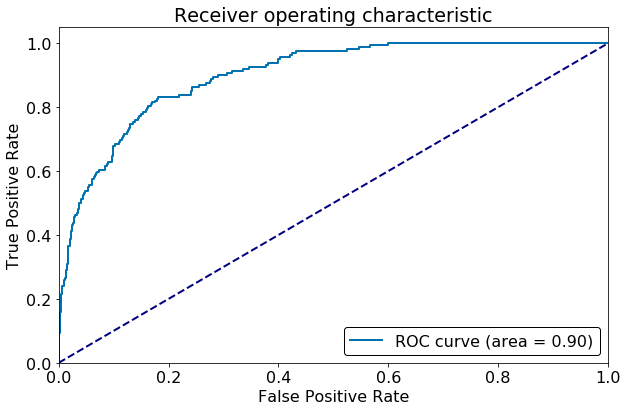

In [14]:
dtest = xgb.DMatrix(Xval)
ypred = bst.predict(dtest)

fpr, tpr, _ = roc_curve(yval, ypred)
roc_auc = auc(fpr, tpr)

plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

lw = 2
plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [15]:
val_acc = accuracy_score(yval, np.round(ypred))
print("validation accuracy: {:.3f}".format(val_acc))

validation accuracy: 0.874


In [16]:
bst.save_model("../Models/xgbNN.model")